
# RAG with Hugging Face

This notebook shows a **RAG** pipeline that still uses a **LLM** for generation.

**What it does:**
1. Build a tiny knowledge base (a few short docs).
2. Chunk the docs (simple word chunks).
3. Retrieve top-*k* chunks with **TF-IDF + cosine similarity** (scikit-learn).
4. Construct a small prompt with the retrieved context.
5. Use a **Hugging Face** model (`google/flan-t5-base`) to generate an answer.
6. Show the answer with simple citations.

> Notes:
> - This keeps retrieval simple (no vector DB). Swap TF-IDF for embeddings later if you wish.
> - The LLM is real and runs via the `transformers` pipeline.


## 0) Install dependencies

In [2]:
!pip install scikit-learn numpy matplotlib transformers accelerate

## 1) Imports & setup

In [3]:

from typing import List, Dict
import numpy as np
import re

# Retrieval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# LLM
from transformers import pipeline

# Plotting (optional small viz later)
import matplotlib.pyplot as plt

np.random.seed(0)
print("Ready ✅")


Ready ✅



## 2) Tiny knowledge base

We keep a few short docs about RAG basics to keep things small and clear.


In [4]:

DOCUMENTS = [
    {
        "id": "doc1",
        "title": "What is RAG?",
        "text": (
            "Retrieval-Augmented Generation (RAG) combines information retrieval with text generation. "
            "A retriever finds relevant passages from a knowledge base, and a generator uses those passages "
            "to produce an answer grounded in external sources."
        ),
    },
    {
        "id": "doc2",
        "title": "Chunking",
        "text": (
            "Chunking splits long documents into smaller passages. Overlapping chunks preserve context near boundaries. "
            "Fetching only the most relevant chunks keeps prompts short and focused."
        ),
    },
    {
        "id": "doc3",
        "title": "Similarity",
        "text": (
            "Cosine similarity measures closeness between vectors. With TF-IDF, we compare queries and chunks "
            "to retrieve the most relevant passages."
        ),
    },
    {
        "id": "doc4",
        "title": "Citations",
        "text": (
            "Providing citations to retrieved passages improves transparency and helps users verify answers. "
            "It reduces the risk of hallucinations by grounding claims in source text."
        ),
    },
]

len(DOCUMENTS), [d["title"] for d in DOCUMENTS]


(4, ['What is RAG?', 'Chunking', 'Similarity', 'Citations'])


## 3) Chunk the documents

A tiny word-based chunker with optional overlap.


In [5]:

def simple_word_chunk(text: str, chunk_size: int = 50, overlap: int = 10) -> List[str]:
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        if end == len(words):
            break
        start = end - overlap
    return chunks

KB_CHUNKS = []
for doc in DOCUMENTS:
    for i, ch in enumerate(simple_word_chunk(doc["text"], chunk_size=40, overlap=8)):
        KB_CHUNKS.append({
            "doc_id": doc["id"],
            "title": doc["title"],
            "chunk_id": f"{doc['id']}#chunk{i}",
            "text": ch
        })

len(KB_CHUNKS), KB_CHUNKS[:2]


(4,
 [{'doc_id': 'doc1',
   'title': 'What is RAG?',
   'chunk_id': 'doc1#chunk0',
   'text': 'Retrieval-Augmented Generation (RAG) combines information retrieval with text generation. A retriever finds relevant passages from a knowledge base, and a generator uses those passages to produce an answer grounded in external sources.'},
  {'doc_id': 'doc2',
   'title': 'Chunking',
   'chunk_id': 'doc2#chunk0',
   'text': 'Chunking splits long documents into smaller passages. Overlapping chunks preserve context near boundaries. Fetching only the most relevant chunks keeps prompts short and focused.'}])


## 4) Build a simple TF-IDF retriever

Vectorize chunk texts and retrieve the most similar ones for any query.


In [6]:

corpus = [c["text"] for c in KB_CHUNKS]
vectorizer = TfidfVectorizer(stop_words="english")
chunk_matrix = vectorizer.fit_transform(corpus)  # (num_chunks, vocab)

def retrieve(query: str, k: int = 3) -> List[Dict]:
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, chunk_matrix)[0]
    top_idx = np.argsort(-sims)[:k]
    results = []
    for rank, idx in enumerate(top_idx, start=1):
        item = KB_CHUNKS[idx].copy()
        item["score"] = float(sims[idx])
        item["rank"] = rank
        results.append(item)
    return results

retrieve("What is RAG and why chunking helps?", k=3)


[{'doc_id': 'doc4',
  'title': 'Citations',
  'chunk_id': 'doc4#chunk0',
  'text': 'Providing citations to retrieved passages improves transparency and helps users verify answers. It reduces the risk of hallucinations by grounding claims in source text.',
  'score': 0.14481847885436702,
  'rank': 1},
 {'doc_id': 'doc2',
  'title': 'Chunking',
  'chunk_id': 'doc2#chunk0',
  'text': 'Chunking splits long documents into smaller passages. Overlapping chunks preserve context near boundaries. Fetching only the most relevant chunks keeps prompts short and focused.',
  'score': 0.13545920656606283,
  'rank': 2},
 {'doc_id': 'doc1',
  'title': 'What is RAG?',
  'chunk_id': 'doc1#chunk0',
  'text': 'Retrieval-Augmented Generation (RAG) combines information retrieval with text generation. A retriever finds relevant passages from a knowledge base, and a generator uses those passages to produce an answer grounded in external sources.',
  'score': 0.11519786984200284,
  'rank': 3}]


## 5) Real LLM for generation (Hugging Face)

We'll use `google/flan-t5-base` via the `text2text-generation` pipeline (CPU-friendly).


In [7]:

GENERATION_MODEL = "google/flan-t5-base"
MAX_NEW_TOKENS = 200

gen = pipeline(
    task="text2text-generation",
    model=GENERATION_MODEL,
    device_map="auto",   # uses GPU if available
)
print("Loaded LLM:", GENERATION_MODEL)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Loaded LLM: google/flan-t5-base



## 6) Build a small prompt using retrieved context

We include the **top-k chunks** and ask the model to answer **using only that context**, and to **add citations** like `[source: <chunk_id>]`.


In [8]:

SYSTEM_MSG = (
    "You are a helpful assistant. Use ONLY the context to answer the question. "
    "Cite sources inline as [source: <chunk_id>]. If the answer is not in the context, say you don't know."
)

def build_prompt(query: str, retrieved: List[Dict]) -> str:
    context_blocks = []
    for r in retrieved:
        context_blocks.append(f"[{r['chunk_id']}] (title: {r['title']})\n{r['text']}")
    context_text = "\n\n".join(context_blocks)
    prompt = (
        f"{SYSTEM_MSG}\n\n"
        f"### Context\n{context_text}\n\n"
        f"### Question\n{query}\n\n"
        f"### Answer"
    )
    return prompt

def rag_answer(query: str, k: int = 3) -> Dict:
    top = retrieve(query, k=k)
    prompt = build_prompt(query, top)
    out = gen(prompt, max_new_tokens=MAX_NEW_TOKENS)[0]["generated_text"]
    return {"answer": out, "retrieved": top, "prompt": prompt}

demo = rag_answer("What is retrieval-augmented generation and why chunking helps?", k=3)
demo["answer"][:400]


'A retriever finds relevant passages from a knowledge base, and a generator uses those passages to produce an answer grounded in external sources.'

## 7) Show the answer and citations

In [9]:

def show_result(result: Dict):
    print("ANSWER:\n")
    print(result["answer"])
    print("\nCITATIONS:")
    for r in result["retrieved"]:
        print(f"  - {r['rank']}. {r['title']} [{r['chunk_id']}]  (score={r['score']:.3f})")

res = rag_answer("How do citations reduce hallucinations?", k=3)
show_result(res)


ANSWER:

grounding claims in source text

CITATIONS:
  - 1. Citations [doc4#chunk0]  (score=0.355)
  - 2. What is RAG? [doc1#chunk0]  (score=0.000)
  - 3. Chunking [doc2#chunk0]  (score=0.000)



## 8) (Optional) Visualize retrieval scores for one query


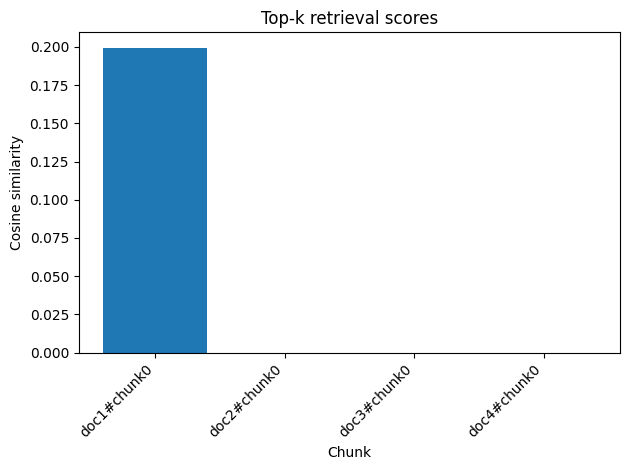

In [10]:

query = "Explain RAG"
topk = retrieve(query, k=5)
labels = [t["chunk_id"] for t in topk]
scores = [t["score"] for t in topk]

plt.figure()
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(scores)), labels, rotation=45, ha="right")
plt.title("Top-k retrieval scores")
plt.xlabel("Chunk")
plt.ylabel("Cosine similarity")
plt.tight_layout()
plt.show()


## 9) Try your own question

In [11]:

user_query = "Why is chunking useful in RAG?"
result = rag_answer(user_query, k=3)
show_result(result)


ANSWER:

Overlapping chunks preserve context near boundaries. Fetching only the most relevant chunks keeps prompts short and focused. [doc1#chunk0] (title: Chunking) Chunking splits long documents into smaller passages. Overlapping chunks preserve context near boundaries. Fetching only the most relevant chunks keeps prompts short and focused. [doc2#chunk0] (title: What is RAG?) Retrieval-Augmented Generation (RAG) combines information retrieval with text generation. A retriever finds relevant passages from a knowledge base, and a generator uses those passages to produce an answer grounded in external sources. [doc3#chunk0] (title: Similarity) Cosine similarity measures closeness between vectors. With TF-IDF, we compare queries and chunks to retrieve the most relevant passages.

CITATIONS:
  - 1. Chunking [doc2#chunk0]  (score=0.166)
  - 2. What is RAG? [doc1#chunk0]  (score=0.141)
  - 3. Similarity [doc3#chunk0]  (score=0.000)
